## Basic concepts of supervised machine learning:

This notebook (or more precisely the person who wrote it) assumes that you are familiar with python at least to some extent. It relies heavily on libraries like numpy, pandas, and matplotlib. They are widely used in machine learning and in 'data science'. 

Before starting make sure you have installed anaconda, and created required conda environment. See supplied README.md file.

***

#### What:
1. Why machine learning (ML) in the first place.
3. Supervised ML - Supervised classification (and regression).
4. What kind of data to use for supervised ML.
5. Features, instances, and labels.
6. Jupyter lab/notebook, pandas, numpy, and matplotlib/seaborn.
6. Train set, validation set, (and test set).
7. We shall build a simple classifier and apply it to trivial classification task.
8. Evaluate the classifiers performace with some metrics (accuracy).
9. Learn that the classifiers are readily available from libraries (sklearn) that you ought to use. How to import and use them.
10. How to evaluate classifier using the libraries.

***
#### Def 1. A computer program is said to learn from *experience* **E** with respect to some class of *tasks* **T** and *performance measure* **P**, if its performance at tasks in **T** as measured by **P**, improves with experience **E**. 

-Mitchell, T. (1997). Machine Learning.

## Why machine learning (ML)?

Quite a few tasks are hard to solve. Say for example you wanted to identify animals present in picture. If you wanted to create a program thaw would pick up a cat given the pixel values in a given image it should be rather apparent that an analytical function that solves such a task is hard to come up with. However, if you look at definition 1, it seems to provide something alternative. Now we do not have to come up with the function image-->animal species, but intead we can try to figure out a model that would take task (identify animal) and minimize some performance measure (fraction of mislabeled animals) with experiences (show images of cats with attached labels in them). Obviously it is not straightforward to come up with such a model and there has been not been way to do this before the increased computational capabilities enabling the capacity of neural networks to increase to levels where they are able to capture such compicated patterns from pictures. We shall here just assume that reader can appreciate the power of Def 1 - given that such a program capable of learning from experience can be deviced.

Even if in many cases there just is not any other feasible option available and one has to resort ot ML methods. It is imperative to keep in mind what one is trying to achieve - always before importing the ML libraries and starting the training, try to figure out if there are some simpler ways to solve the given task than with the most elaborate ML methods. After all one wants to use the simplest model capable of solving a given task in spirit of Occams razor: "when presented with competing hypotheses about the same prediction, one should select the solution with the fewest assumptions". 

There are vast amount of situations where more traditional statistical methods/phenomenoligical modeling can give great insights into the studied system, and while ML (and in particular ANNs) can be applied it might lack the interpretability of these more traditional methods, see for [example](https://community.fico.com/s/blog-post/a5Q2E0000001czyUAA/fico1670). This is to say that one should only use ML after simple approaches have failed, but some output is still expected. Consider for example that you are handed with data of various properties boats and you should infer the owners income - there is not much ML to be done just find a parameters $a, b$ and the income will me *boat_length * a + b = owner_income* ;). On the other hand you could be given a bunch of audio data of whale singing an a task to label the whale species - I suppose (I do not know much of whales..) it is pretty hard and at least I would give up more or less immediately and try to employ ML on the task. However, it is always important to keep in mind to try to build the simplest possible model first and evaluate the performance of the more complicated model against this simple model to asses whether the more elaborate model is actually producing any increase in performance. 

All of the above examples are of supervied learning and that is the main topic of this notebook. You are handed with a bunch of data (boat_lengths, owner_incomes), (whale_sounds, whale_species) and you are asked to build a model to deduce something (=*label* or *event*) from something else (=*features* $\mathcal{F}$). You need to build a *model/program* $\mathcal{M}$ that takes in $\mathbf{x}$ and gives out *target* $y$. That is, $\mathcal{M}(\mathbf{x}) = y$. We shall formalize this slightly.

### Supervised ML:
Supervised ML is about estimating probabilities of events using already seen training data $(\mathbf{X}_\text{train}, \mathbf{y}_\text{train})$ and model $\mathcal{M}$. We assume that there exists some reasonable underlying function $f(\mathbf{x})=y$ that we try to estimate. The term *supervised* comes from the idea that there exists some sort of teacher to the ML model providing the correct target labels $\mathbf{y}_\text{train}$ for the training inputs.

In the following we shall work only with tabular data. That is, data $\mathbf{X}$, that can be presented as a table. The column labels in $\mathbf{X}$ are called *features* they can be whatever attributes that are available of each *item/input* $\mathbf{x}$. The feature values of *item/input* $\mathbf{x}$ are the elements of the instance $\mathbf{x} = [x_{\text{f}_1},\ldots,x_{\text{f}_N}]$. Pair $(\mathbf{x}, y)$ of *item* and *label* is called an *instance*. We have a model $\mathcal{M}$ that is trained using some method and the training data so that:

$
\mathcal{M} = \text{Train}(\mathcal{M}, \mathbf{X}_\text{train}, \mathbf{y}_\text{train}),
$ 

and after training: 

$\mathcal{M}(\mathbf{x}) \approx y$.

If the target is categorical like animal species the task is supervised **classification**, while if the target is continuos, say we want to predict the expected sales price of a house the task is supervised **regression**. For simplicity in the following we shall only consider classification regression is left to later lectures.
***
#### Let us by importing all the required libraries.


In [1]:
# Import the required libraries
import pandas as pd # Pandas deals with handling data. 
import numpy as np # Numpy provides a lot of FAST ways for array manipulation in python.
import matplotlib.pyplot as plt # Plotting script library
import matplotlib as mpl # Plotting
import seaborn as sns # More plotting

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".99"})
sns.set_style("ticks")

## Supervised Classification:

Let us now walk through an elementary task where a set of data is given and a question is proposed in the form: "given this input, could you tell me the target label?". That is:

**inputs $\rightarrow$ model $\rightarrow$ predictions**

Or:

The task is to predict the target class $y_i$ for given item $\mathbf{x}\in\mathbf{X}_\text{test}$ using the chosen model $\mathcal{M}$ and the information available in the training data ($\mathbf{X}_\text{train}, \mathbf{y}_\text{train}$). The fact that the test item $\mathbf{x}$ is not available in the training set is a necessary requirement for the learning process to be of importance for else one could just memorize the training set and the model would not need to *generalize* outside the training data. Obviously also in practice you do not anticipate to have seen the exact inputs previously while training, if you did why would you then do ML in the first place? Thus, in order to evaluate the anticipated performance of your ML model always resrve a test set that you do not look at until the very end.

***

### First we would like to import some example data to work with:

We shall try to infer the penguin species from some penguin dimensions. 

In [2]:
# Use seaborn to load simple toybox dataset: (you can list all the available datasets by: sns.get_dataset_names())
# It will return a pandas dataframe. DataFrames are super convenient way of storing tabular data.
data = sns.load_dataset('penguins')

# Remove the test set already now before even seeing anything.
data_test = data.sample(20)
# Drop the test set from training set!!
data = data.drop(data_test.index)

data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


### Data handling using pandas:

In [3]:
b = pd.DataFrame()
b['dtypes'] = data.dtypes # Show the datatypes of columns
b['counts'] = data.nunique() # Number of unique values
b

,dtypes,counts
species,object,3
island,object,3
bill_length_mm,float64,157
bill_depth_mm,float64,77
flipper_length_mm,float64,55
body_mass_g,float64,93
sex,object,2


In [4]:
data.loc[:, 'species'] # access a single column equivalent to: data.species 

0      Adelie
1      Adelie
2      Adelie
3      Adelie
4      Adelie
        ...  
339    Gentoo
340    Gentoo
341    Gentoo
342    Gentoo
343    Gentoo
Name: species, Length: 324, dtype: object

In [5]:
# Pick random sample:
idxs = np.random.choice(data.index, size=3)
# Use the random idxs to pick up rows and sort values based on (bill_depth_mm):
data.loc[idxs, :].sort_values('bill_depth_mm') # take rows indexed with idxs and sort w.r.t. bill depth

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
241,Gentoo,Biscoe,45.1,14.5,215.0,5000.0,Female
131,Adelie,Torgersen,43.1,19.2,197.0,3500.0,Male


In [6]:
data.loc[3:10, ['species', 'island']] # access idxs 3 to 9 and columns species, island

,species,island
3,Adelie,Torgersen
4,Adelie,Torgersen
6,Adelie,Torgersen
7,Adelie,Torgersen
8,Adelie,Torgersen
9,Adelie,Torgersen
10,Adelie,Torgersen


In [7]:
# Check the species means for all numerical features:
data.groupby('species').mean()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
species,,,,
Adelie,38.832168,18.339860,190.118881,3705.594406
Chinstrap,48.771429,18.406349,195.714286,3726.984127
Gentoo,47.550862,15.020690,217.336207,5083.189655


In [8]:
# Or even:
df = data.groupby(['species', 'sex']).mean()
df.style.bar(subset=['bill_length_mm', 
                     'bill_depth_mm', 
                     'flipper_length_mm',
                     'body_mass_g'], 
             color='DarkSlateGray')

In [9]:
# Cut in 4 equally intervalled groups:
pd.cut(data.bill_length_mm, 4, retbins=True)

(0       (38.975, 45.85]
 1       (38.975, 45.85]
 2       (38.975, 45.85]
 3                   NaN
 4      (32.072, 38.975]
              ...       
 339                 NaN
 340     (45.85, 52.725]
 341     (45.85, 52.725]
 342     (38.975, 45.85]
 343     (45.85, 52.725]
 Name: bill_length_mm, Length: 324, dtype: category
 Categories (4, interval[float64]): [(32.072, 38.975] < (38.975, 45.85] < (45.85, 52.725] < (52.725, 59.6]],
 array([32.0725, 38.975 , 45.85  , 52.725 , 59.6   ]))

In [10]:
# Cut in 4 equally sized groups:
pd.qcut(data.bill_length_mm, 4, retbins=True)

(0      (32.099000000000004, 39.5]
 1      (32.099000000000004, 39.5]
 2                   (39.5, 44.45]
 3                             NaN
 4      (32.099000000000004, 39.5]
                   ...            
 339                           NaN
 340                 (44.45, 48.5]
 341                  (48.5, 59.6]
 342                 (44.45, 48.5]
 343                  (48.5, 59.6]
 Name: bill_length_mm, Length: 324, dtype: category
 Categories (4, interval[float64]): [(32.099000000000004, 39.5] < (39.5, 44.45] < (44.45, 48.5] < (48.5, 59.6]],
 array([32.1 , 39.5 , 44.45, 48.5 , 59.6 ]))

In [11]:
# Check if there are missing information in the dataframe:
data.isnull() # find the nan values from df  
display(data.loc[data.isnull().any(axis=1), :])
print('# instances with NaN values: {}'.format(data.isnull().any(axis=1).sum()))

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


# instances with NaN values: 10


#### Math operations on dataframes:

In [12]:
data.loc[:, 'bill_length_mm'] * 2 + 10

0       88.2
1       89.0
2       90.6
3        NaN
4       83.4
       ...  
339      NaN
340    103.6
341    110.8
342    100.4
343    109.8
Name: bill_length_mm, Length: 324, dtype: float64

### The first thing you always need to do (if you want to evaluate your classifiers performance) is to separate the data into train, valid, and test sets!

We further decide to build a classifier that would try to identify the penguin species given only the 2-features (xlabel, ylabel). Here we skip the test set since we are not interested in the actual model performance, we are not going to deploy our penguin classifier.

In [41]:
target = 'species'
xlabel = 'bill_length_mm'
ylabel = 'bill_depth_mm'

# shuffle the data and pad rows that have missing values.
data = data.sample(frac=1).dropna() # fillna(method='pad')
X = data.drop(columns=[target])  
X = X.loc[:, [xlabel, ylabel]]
y = data.species

N_train = 300
X_train = X.iloc[:N_train]
y_train = y.iloc[:N_train]
X_valid = X.iloc[N_train:]
y_valid = y.iloc[N_train:]


#### Before doing any ML one should try to explore a bit how the data is distributed and can we extract some information out of it:

One way is to check the histograms of feature values for each of the target classes separately. This is easily achieved by seaborn plotting utilities or pyplot. 

Histograms


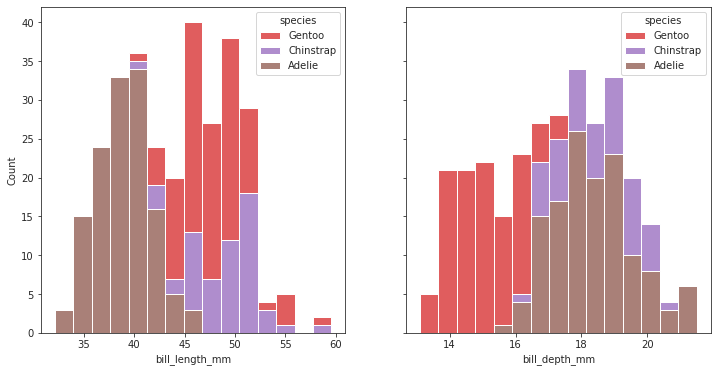

Boxplots


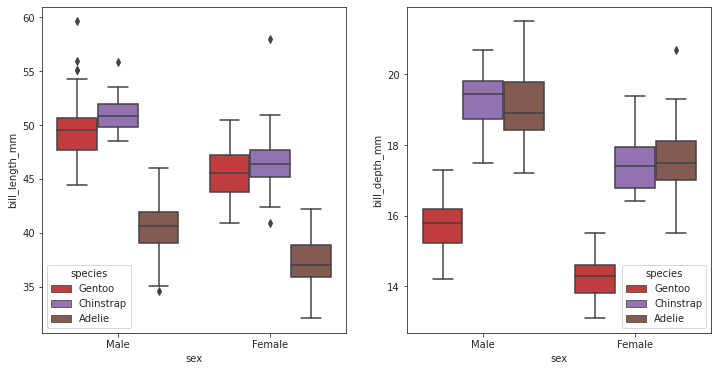

In [49]:
way_kw = "stack"  #'layer' #
nbins = 15
penguin_palette = {sp:'C{}'.format(i+3) for i, sp in enumerate(y_train.unique())}

_, axarr = plt.subplots(1,2, sharey=True)
print('Histograms')
for c, ax in zip(X_train.columns, axarr):
    _ = sns.histplot(X_train, x=c, hue=y_train, multiple=way_kw, hue_order=y_train.unique(), ax=ax, bins=nbins, palette=penguin_palette)
plt.show()

_, axarr = plt.subplots(1,2)
print('Boxplots')
for c, ax in zip(X_train.columns, axarr):
    _ = sns.boxplot(data=X_train, x=data.loc[X_train.index, 'sex'], hue=y_train, y=c, ax=ax, palette=penguin_palette) #, multiple=way_kw, hue_order=y_train.unique(), ax=ax, bins=nbins)

In [43]:
X_train, y_train

(     bill_length_mm  bill_depth_mm
 229            46.8           15.4
 200            51.5           18.7
 309            52.1           17.0
 63             41.1           18.2
 7              39.2           19.6
 ..              ...            ...
 171            49.2           18.2
 39             39.8           19.1
 274            46.5           14.4
 251            42.8           14.2
 333            51.5           16.3
 
 [300 rows x 2 columns],
 229       Gentoo
 200    Chinstrap
 309       Gentoo
 63        Adelie
 7         Adelie
          ...    
 171    Chinstrap
 39        Adelie
 274       Gentoo
 251       Gentoo
 333       Gentoo
 Name: species, Length: 300, dtype: object)

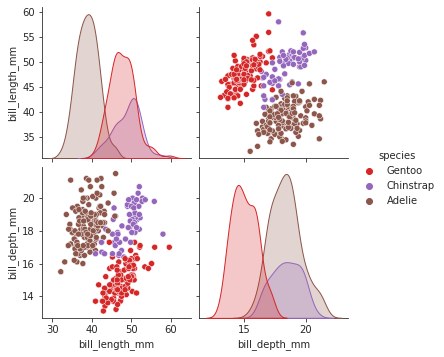

In [50]:
_ = sns.pairplot(pd.concat((X_train, y_train), axis=1), hue='species', palette=penguin_palette)

#### Then let us quickly plot some of the xlabel, ylabel and color the scatter by the target:

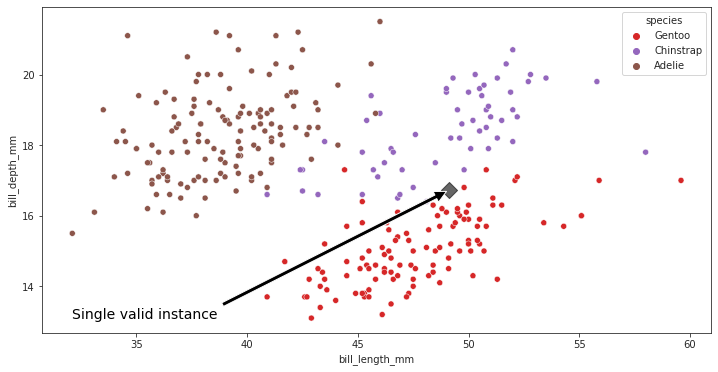

In [51]:
def plot_penguins(test_xy=None, idxs=None):
    
    # Make a scatter plot of the xlabel, ylabel values colored by the target class::
    if idxs is None: idxs = X_train.index
        
        
    ax = sns.scatterplot(data=X_train.loc[idxs, :], 
                         x=xlabel, 
                         y=ylabel, 
                         hue=y_train.loc[idxs], 
                         #style=data.island, 
                         hue_order=y_train.unique(),
                         palette=penguin_palette)

    if test_xy is not None:
        # Plot a text instance with annotation:
        ax.scatter(*test_xy, color='black', marker='D', s=130, alpha=.60)
        _ = ax.annotate('Single valid instance', test_xy, 
                        color='black', 
                        xytext=X_train.loc[idxs, :].min(), 
                        arrowprops=dict(facecolor='black', shrink=0.01),
                        fontsize=14) 
    
    return ax

test_xy=X_train.loc[y_train.isin(['Gentoo', 'Chinstrap']), :].mean() + [1, .5]

_ = plot_penguins(test_xy)

#### We now would like to build a classifer $C$ that is cabable of figuring out the species of penguin given the xlabel and ylabel defined earlier.

Recall, a classifier $C$ is a mapping from the feature values to probabilites of classes:

$
C : \mathcal{F} \rightarrow [0,1]^{\text{nclasses}}
$

That is, for given item $\mathbf{x}$ we have $\mathcal{C}(\mathbf{x})=[p_\text{Adelia}, p_\text{Chinstrap}, p_\text{Gentoo}]$, where $p_i$ is the probability for species $i$.

We need to figure out a classifier $\mathcal{C}$ that in *task* of classifying unseen test instances (xlabel, ylabel) to penguin specieses, can improve by *experience* of being provided more training examples, in *performance* that measures the fraction of correct predictions. Looking at the figure above it is evident that for any given $\mathbf{x}$ we could consider some 'similarity' measure - how similar this $\mathbf{x}$ is to some item in the already seen data of penguins. Remember that in the above we only showed the training data. 

Let us propose,

$p_i = \mathcal{C}({\mathbf{x}})_i \propto \frac{1}{min(\{ D(\mathbf{x}, \mathbf{x}') : \mathbf{x}' \in X_\text{train} \})}$,

Now the predicted class is always the class corresponding to item $\mathbf{x}'\in\mathbf{X}_\text{train}$ for which the distance $D(\mathbf{x}, \mathbf{x}')$ is minimized. Such a classifier is called first nearest neighbor classifier for the obvious reason that it picks the class label for item $\mathbf{x}$ to equal the class label of $\mathbf{x}' \in \mathbf{X}_\text{train}$ for which distance $D(\mathbf{x}, \mathbf{x}')$ is the smallest. This becomes crystal clear in the following example.
***

### Make knn-classifier class:

The above described 1-nn classifier can immediately be generalized into knn classifier, where istead of the single nearest neighbor we consider the $k$ nearest neighbors (knn). 

Let 

$nn_{\mathbf{x}} = \{ (\mathbf{x}', y) : \text{the k nearest neighbors as given by distance metric } D(\mathbf{x}, \mathbf{x}'), ~ \mathbf{x}' \in \mathbf{X}_\text{train}  \}
$

We get the probability for class $y_i$ via 

$p(y_i) = |\{y:  nn_\mathbf{x}(y) = y_i \}|/k$

If you feel uncomfortable with the above, wait for the example and it'll all be good.

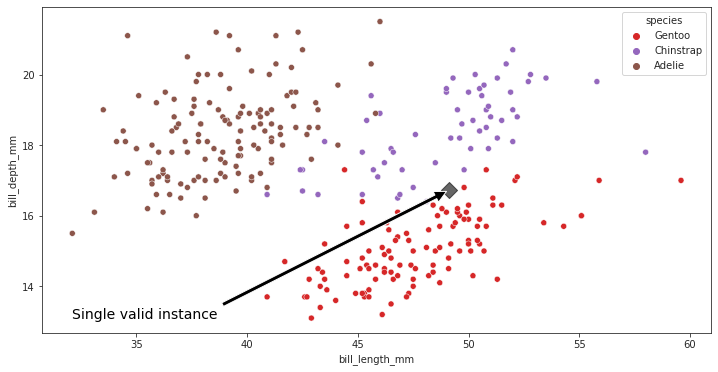

In [52]:
_ = plot_penguins(test_xy)

In [53]:
class knn_classifier():
    """
    This is a simple knn classifier to demonstrate how one can build a classifier.
    NOTE!
    You should not build your own classifiers but rather use already implemented ones from
    libraries like scikit-learn, tensorflow etc. Reasons to make one yourself are
    1. You think you can do it better than rest.
    2. You want to learn how a classifier works and thus build it yourself.
    """
    def __init__(self, k=1):
        self.k = k
    
    def fit(self, X_train, y_train):
        """
        We fit the knn classifier by providing the training data and corresponding labels.
        Args:
            X_train: The training data.
            y_train: The training data class labels.
        Return:
            self:
        """
        self.X_train = X_train.values
        self.y_train = y_train.values
        
        return self
    
    def predict(self, x):
        """
        Predict using the knn classifier.
        Args:
            x: predict for this instance.
        Returns:
            y_pred: Predicted class labels.
            probs: Probabilitites of y_pred
            neighbor_idxs: List of indices of the nearest neighbors (used for plotting).
        """
        if (self.X_train is None) or (y_train is None):
            raise AttributeError('Classifier is not fitted!')
        
        if isinstance(x, pd.Series):
            x = x.values
        
        # These are the distances to all values in the training set:
        distances = np.sqrt(((self.X_train - x)**2).sum(axis=1))
        
        sort_idx = distances.argsort()
        
        # This is just bunch of numpy things to figure out the nearest neightbors.
        # In jupyter lab you can always inspect the documentation of a function by typing: ??np.unique
        targets, counts = np.unique(self.y_train[sort_idx[:self.k]], return_counts=True)
        probs = counts/counts.sum()
        sort_probs_idx = probs.argsort()
        
        return targets[sort_probs_idx], probs[sort_probs_idx], sort_idx[:self.k]
        

### Apply the above knn classifier to infer the class labels of unseen instances $\mathbf{x}$.

True class: Adelie
P(Chinstrap) = 0.333
P(Adelie) = 0.667


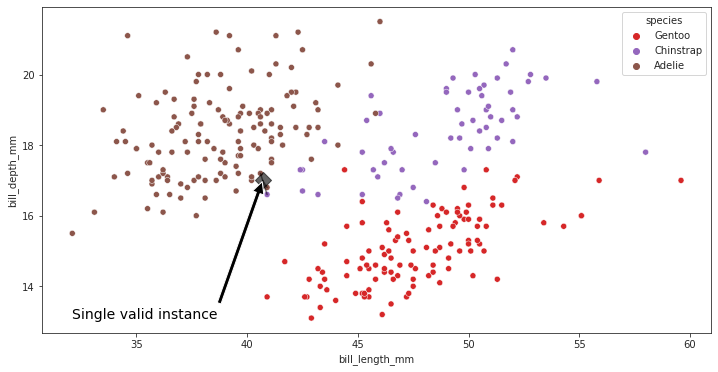

In [54]:
# The number of neighbors to consider:
k = 3
test_idx = 0

# Create and fit the classifier:
def get_knn_plot(N, plot=False):
    """
    Return a knn clf fitted with only N of the training instances:
    """
    train_idxs = np.random.choice(X_train.index, replace=False, size=min(N, len(X_train)))
    
    
    knn = knn_classifier(k=k).fit(X_train.loc[train_idxs, :], y_train.loc[train_idxs])
    
    if not plot: return knn
    
    # Pick a test index, the test instance is then drawn from the above separated test set.
    X_valid_instance = X_valid.iloc[test_idx]

    # Call the predict of knn classifier:
    y_preds, probs, idxs = knn.predict(X_valid_instance)

    # Print the probabilites for each class:
    prob_str = 'P({0:}) = {1:.3f}'
    print('True class: {}'.format(y_valid.iloc[test_idx]))
    for y_pred, prob in zip(y_preds, probs):
        print(prob_str.format(y_pred, prob))

    # Plot figure where the nearest neighbors are explicitly shown:
    xtest_x = X_valid_instance.loc[xlabel] 
    xtest_y = X_valid_instance.loc[ylabel]
    ax = plot_penguins((xtest_x, xtest_y), idxs=train_idxs)

    for idx in idxs:
        nn_x = X_train.loc[train_idxs, :].iloc[idx][xlabel]
        nn_y = X_train.loc[train_idxs, :].iloc[idx][ylabel]
        ax.plot([xtest_x, nn_x], [xtest_y, nn_y], color='black', alpha=.5)
    


    plt.show()
    return knn
    
ntrain = 400
_ = get_knn_plot(ntrain, plot=True)

### Classifier performance evaluation:

Looking at the above figure it is pretty obvious that one does not need complicated model to figure out the penguin species given the two features. However, we might ask questions like: "How good is the classifier that we just built?". How do we estimate it? 

The first thing to note is again - you test with *unseen* data! For example 1-nn classifier would always yield the correct class when tested with data that was used to train it. Notice how the training (fit) of the knn classifier above was only storing the training data and labels. The importance of separating the data into training and testing sets cannot be emphasized enough! We shall later also consider validation set, but this is not needed yet.

Anyhow, suppose you remebered to make the division and now you are to evaluate the the performance of you classifier using the *unseen* test data $(\mathbf{X}_\text{test}, \mathbf{y}_\text{test})$. The most obvious measure of performance for your classifier could be: 

$
\text{accuracy} = \frac{\text{number_of_correct_predictions}}{\text{number_of_predictions}}.
$

However, accuracy has several noted issues. Consider for example situation where you want to pick a rare disease (only 1 person in 100 000 has it) and you receive an accuracy score of 99.999%! You think you are doing great, but think twice. You notice the issue? 

However, we for now use accuracy to demonstrate the evaluation process. 

In [61]:
def get_score(ntrain):
    # initialize a prediction array:
    y_preds = np.zeros(len(X_valid), dtype='object')

    # loop over the test set and perform prediction of each element in test set:
    for i, X_valid_instance in enumerate(X_valid.values):
        # Predicted class is the one with largest probability, which in turn is the last element in the list.
        knn = get_knn_plot(ntrain)
        y_preds[i] = knn.predict(X_valid_instance)[0][-1]

    #compare y_preds element vise with the known truth y_valid
    correct_prediction_array = y_preds == y_valid.values

    # accuracy is the fraction of correct predicions over all predictions
    accuracy = correct_prediction_array.sum()/len(y_preds)

    print('# of train instances: {}'.format(ntrain))
    print('Accuracy of the {}-nn model is {:.1f}%'.format(k, 100*accuracy))
    
    return y_preds

for ntrain in [10,30,60,100,300]:
    y_preds = get_score(ntrain)
    print()

# of train instances: 10
Accuracy of the 3-nn model is 79.2%

# of train instances: 30
Accuracy of the 3-nn model is 87.5%

# of train instances: 60
Accuracy of the 3-nn model is 91.7%

# of train instances: 100
Accuracy of the 3-nn model is 95.8%

# of train instances: 300
Accuracy of the 3-nn model is 95.8%



Remember again Def 1. What we now have is exactly what was described there. Think what are the experience, task, and performance metrics here? 
***
The simple knn classifier seems to provide rather good results, but the process was tedious and can be significantly simplified. It was anyhow nice to walk such a process though - it hopefully gave rather solid understanding how one can start just from the Def 1 and some data and build a true system capable of learning. It covered most of the steps you always need to do.
1. Getting the data
2. Splitting the data to taining and testing sets
3. Making some initial plots of the data and figuring out what we are trying to achieve.
4. Figuring out how to achieve the above goal (here knn-classifier).
5. Demonstrating the performance of the proposed method in the test set.

## Going real - use libraries!

Obviously in the real world we are not going to be building classifiers and evaluating metrics in the manner presented above - this would be quite time consuming and also error prone. This all has been prebuild into libraries. In python the most popular is [scikit-learn](https://scikit-learn.org/stable/). Let us now see how the above would have been done using *scikit-learn*.

In [66]:
# Import the knn classifier class and a cross validation function from sklearn libraries.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Create the classifier
knn_sk = KNeighborsClassifier(n_neighbors=k)

# Choose the performance evaluation metric:
metric = 'accuracy'

# Fit the classifier:
knn_sk.fit(X_train, y_train)

# Predict using the sk learn classifier:
y_preds_sk = knn_sk.predict(X_valid)

# Check the score:
accuracy_score(y_valid, y_preds_sk)

0.9583333333333334

#### Whys is the result not equal to the one we had earlier!?

In [67]:
mask = y_preds != y_preds_sk
X_differing = X_valid.loc[mask, :]  #
if len(X_differing) != 0:
    
    for i in range(len(X_differing)):
        print('Our knn:')
        print(*knn.predict(X_differing.iloc[i,:].values)[:2], '-->', y_preds[mask][i])
        print('scikit knn:')
        #print(knn_sk.classes_)
        print(knn_sk.predict_proba(X_differing.iloc[i, :].values.reshape(1,-1))[0], '-->', y_preds_sk[mask][i])
else:
    print('They did not differ...')

They did not differ...


#### Using cross validation:

In [69]:
from sklearn.model_selection import cross_validate



knn_sk = KNeighborsClassifier(n_neighbors=k)

data = sns.load_dataset('penguins').dropna() #fillna(method='pad')
X = data.loc[:, [xlabel, ylabel]]
y = data.loc[:, target]

# Perform cross validation (cross validation takes care of train, valid splitting under the hood.)
test_scores = cross_validate(knn_sk, X, y, cv=10, scoring=metric)['test_score']

# Show results:
for i, score in enumerate(test_scores):
    print('{} in test split {} = {:.1f}%'.format(metric, i, 100*score))

print()
print('{} = {:.3f}, std = {:.3f}'.format(metric, test_scores.mean(), test_scores.std()))    

accuracy in test split 0 = 97.1%
accuracy in test split 1 = 100.0%
accuracy in test split 2 = 97.1%
accuracy in test split 3 = 97.0%
accuracy in test split 4 = 93.9%
accuracy in test split 5 = 97.0%
accuracy in test split 6 = 97.0%
accuracy in test split 7 = 93.9%
accuracy in test split 8 = 97.0%
accuracy in test split 9 = 97.0%

accuracy = 0.967, std = 0.016


#### Lets go through the above:

First one imports the **KNeighborsClassifier** and a function to perfrom cross validation.

The data is then selected as before - this is just to remind ourselves where the data came from.

Create the knn classifier.

Choose a performance evalaution metric - here accuracy.

Perform the **cross validation**. Now this is different from above, where we only evaluated the perfromance our knn-classifier in a single valid set. Cross validation is basically just splitting the data into N slices. Each of the N slices is at its time the valid set while the rest of the data is used for training the classifier (knn). This is useful and give more confidence into the performance evaluation process, since you can be confident that you did not accidentally pick up the easiest possible valid set - every instance in the data will be at their time part of the valid set as well.



### Questions:
1. What are features, items, labels, and instances?
2. Does a item always have equaly many elements?
3. How many labels there are in the train set as compared to the number of items?
etc.etc.